Use county centroids as points, and assign weights (e.g. overdose rates).

For each year:

Build a weighted point cloud or distance matrix.

Create a Vietoris-Rips complex.

Compute persistence.

Use Wasserstein or bottleneck distance to compare diagrams over time.

Optionally cluster or visualize trends using UMAP or MDS.

# ZigZag Persistence

In [2]:
import pandas as pd

In [3]:
# pyenv virtualenv 3.11.9 dionysus311
# python3 -m venv dionysus311

In [4]:
import dionysus as d
print(d.__version__)


2.0.10


# Zigzag Persistence

## We generalize ordinary persistent homology by allowing the connecting maps to point in either direction $H_{*}(K_1) \to H_{*}(K_2) \leftarrow H_{*}(K_3) \rightarrow H_{*}(K_4) \leftarrow \ldots $

## To realize a zigzag filtration we begin with a maximal simplicial complex $\bigcup_{i}K_{i}$ and encode the data as a d.Filtration(), parametrized by time.

In [7]:
f = d.Filtration([[0],[1],[2],[0,1],[0,2],[1,2]])

### For each simplex in the complex, we keep track of the time when the simplex first appeared and the time when it first disappeared. In code, this is a list of lists ("times"). For the ith simplex in the filtration, "times[i]" is a list of times where times in the even positions (counting from 0) correspond to times when the simplex was added and odd positions correspond to when the simplex was removed.

In [8]:
times = [[.4, .6, .7], [.1], [.9], [.9], [.9], [.9]]

### Given these two inputs, we can compute the "zigzag persistent homology" of the corresponding sequence of simplicial complexes using "zigzag_homology_persistence()".

In [9]:
zz, dgms, cells = d.zigzag_homology_persistence(f, times)

### The function returns a triple; an internal representation of ZigZagPersistence which stores -
- (zz) cycles still alive in the rightmost homology group in the sequence,
- (dgms) the persistence diagrams that represent the decomposition of the sequence, 
- (cells) auxillary map to translate from internal indices used in the cycles into indices of the simplicies in "Filtration()"

In [10]:
# print(zz)

# for i,dgm in enumerate(dgms):
#     print("Dimension:", i)
#     for p in dgm:
#         print(p)

for z in zz:
    print(z)

for x in sorted(cells):
    print(x)

1*0
1*4 + 1*5 + 1*6
(0, 1)
(2, 0)
(3, 2)
(4, 3)
(5, 4)
(6, 5)


### Representative Cycles
The first and third element of the triple (combined) can be used to extract representative cycles. The third element is the map from the cycle's internal representation to the filtration indices. The following snippet outputs the cycles in terms of the simplices.

In [11]:
# outputs the cycles in terms of the simplices.
for z in zz:
    print(' + '.join("%d * (%s)" % (x.element, f[cells[x.index]]) for x in z))


1 * (<1> 0)
1 * (<0,1> 0) + 1 * (<0,2> 0) + 1 * (<1,2> 0)


## Intermediate Steps
zigzag_homology_persistence() takes an optional callback argument, which gets called back agrer every step of the zigzag. The function takes four inputs $(i,t,d,zz)$
- i -  the index of the simplex being added or removed
- t - the current time
- d - the direction (True if the simplex is being added, False if it is being removed)
- zz -  the current state of ZigZag Persistence

In [12]:
def detail(i,t,d,zz,cells):
    print(i,t,d)
    for z in zz:
        print(z, ' -> ', ' + '.join("%d * (%s)" % (x.element, f[cells[x.index]]) for x in z))

zz, dgms, cells = d.zigzag_homology_persistence(f, times, callback = detail)

1 0.10000000149011612 True
1*0  ->  1 * (<1> 0)
0 0.4000000059604645 True
1*0  ->  1 * (<1> 0)
1*1  ->  1 * (<0> 0)
0 0.6000000238418579 False
1*0  ->  1 * (<1> 0)
0 0.699999988079071 True
1*0  ->  1 * (<1> 0)
1*2  ->  1 * (<0> 0)
2 0.8999999761581421 True
1*0  ->  1 * (<1> 0)
1*2  ->  1 * (<0> 0)
1*3  ->  1 * (<2> 0)
3 0.8999999761581421 True
1*0  ->  1 * (<1> 0)
1*3  ->  1 * (<2> 0)
4 0.8999999761581421 True
1*0  ->  1 * (<1> 0)
5 0.8999999761581421 True
1*0  ->  1 * (<1> 0)
1*4 + 1*5 + 1*6  ->  1 * (<0,1> 0) + 1 * (<0,2> 0) + 1 * (<1,2> 0)



Dimension 0
(0.4,0.6)
(0.7,0.9)
(0.1,inf)

Dimension 1
(0.9,inf)


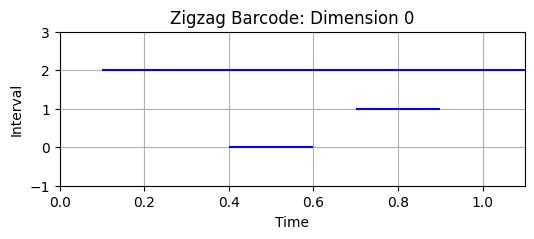

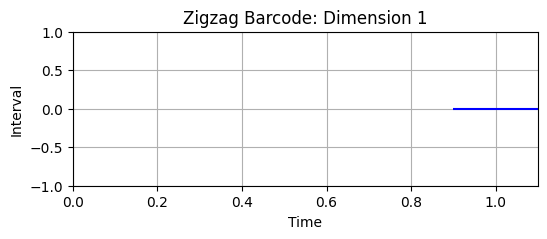

In [13]:
import dionysus as d
import matplotlib.pyplot as plt


# Compute zigzag persistence
zz, dgms, cells = d.zigzag_homology_persistence(f, times)

# Print the results
for dim, dgm in enumerate(dgms):
    print(f"\nDimension {dim}")
    for pt in dgm:
        print(pt)

# Plotting barcode diagram
def plot_barcode(dgm, dim):
    plt.figure(figsize=(6, 2))
    for i, pt in enumerate(dgm):
        b = pt.birth
        d = pt.death if pt.death != float('inf') else 1.1
        plt.hlines(y=i, xmin=b, xmax=d, colors='blue')
    plt.title(f"Zigzag Barcode: Dimension {dim}")
    plt.xlabel("Time")
    plt.ylabel("Interval")
    plt.ylim(-1, len(dgm))
    plt.xlim(0, 1.1)
    plt.grid(True)
    plt.show()

# Plot both dimensions
for dim, dgm in enumerate(dgms):
    plot_barcode(dgm, dim)


#### Why Thresholding Is Necessary in This Setup
Zigzag persistence tracks how topological features (like connected components or loops) appear and disappear over time or across filtrations. In your case, there isn't a natural time evolution — so we create a filtration across different thresholds of overdose death counts to reveal patterns.
#### The Core Idea
We treat "death count threshold" as a filtering lens:
At a low threshold (say, 5 deaths), most counties are included, forming a broad network.
At a higher threshold (say, 25 deaths), only the most severely affected counties remain — and this may break the space into disconnected pieces, loops, or clusters.
Zigzag persistence lets us analyze how these topological features evolve across different levels of severity.
#### Why Not Just Use Raw Data?
If we didn't apply thresholds:
We'd just have a static point cloud of counties.
We'd need to use standard persistence (not zigzag).
We'd miss the dynamics of "which parts of the state form patterns at which severity levels".
Thresholding lets us:
Observe how spatial structure changes as we only consider counties with deaths above a certain level.
Identify persistent features: if a loop or cluster of counties appears across several thresholds, it’s more meaningful than a fleeting one.
#### Why Use Quantiles or Mean±Std for Thresholds?
Instead of arbitrary values (e.g., [10, 20, 30]), we want data-driven cutoffs that:
Reflect your data distribution.
Ensure meaningful differences across slices.
Avoid thresholds that are too tight (few points survive) or too loose (everyone stays in).
This gives your zigzag barcode interpretable, grounded structure.

In [14]:
df = pd.read_csv('/Users/joshturner/Desktop/DrugOverdoseTDAVA/Data/VDHPUDOverdoseDeathsByYearAndGeographyLongLat.csv')

In [17]:
df.dtypes

Unnamed: 0                                     int64
_id                                            int64
Data Extract Date                             object
Overdose Death Year                            int64
Overdose Death Drug Class                     object
Overdose Death Geography Level                object
Overdose Death FIPS                            int64
Overdose Death Geography Name                 object
Overdose Death Health District                object
Overdose Death Count                         float64
Overdose Death Rate per 100,000 Residents     object
County                                        object
Latitude                                     float64
Longitude                                    float64
dtype: object

In [ ]:
# # Keep only digits in the Year column
# df['Overdose Death Year'] = df['Overdose Death Year'].str.extract('(\d{4})')  # Extracts 4-digit year
# df['Overdose Death Year'] = pd.to_numeric(df['Overdose Death Year'], errors='coerce')  # Convert to numeric (int or NaN)
# # Keep only digits in the Year column
# # mapper_data['Overdose Death Count'] = mapper_data['Overdose Death Year'].str.extract('(\d{4})')  # Extracts 4-digit year
# df['Overdose Death Count'] = pd.to_numeric(df['Overdose Death Count'], errors='coerce')  # Convert to numeric (int or NaN)


In [ ]:
df['Overdose Death Drug Class']

In [18]:
df_filtered1 = df[['Overdose Death Year','Overdose Death Drug Class','County','Latitude',
       'Longitude','Overdose Death Count']]

In [19]:
df_filtered1["Overdose Death Year"].min()

np.int64(2019)

## Unique Counties One Year

In [20]:
df_2019 = df_filtered1[df_filtered1["Overdose Death Year"] == 2019].dropna(subset=["Latitude", "Longitude"])
# df_2019 = df_2019[df_2019['Overdose Death Drug Class'] == "All-Drug"]
df_2019 = df_2019.drop_duplicates(subset='County')

df_2019 = df_2019.reset_index(drop=True)


In [21]:
df_2019.shape

(134, 6)

### A Comparison of Thresholds

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulate example overdose data for one year (e.g., 2022)
np.random.seed(42)
# Calculate thresholds using both methods
mean = df_2019['Overdose Death Count'].mean()
std = df_2019['Overdose Death Count'].std()
quantiles = df_2019['Overdose Death Count'].quantile([0.25, 0.5, 0.75]).tolist()
num_counties = df_2019['County'].nunique()
# Create thresholds using mean±std and quantiles
thresholds_mean_std = [mean - std, mean, mean + std]
thresholds_quantiles = quantiles

# Plot comparison of how many counties are above each threshold
def plot_thresholds(thresholds, method_name):
    counts = [np.sum(df['Overdose Death Count'] >= t) for t in thresholds]
    labels = [f"≥{round(t, 1)}" for t in thresholds]
    
    plt.bar(labels, counts, color='skyblue')
    plt.title(f"Counties above thresholds ({method_name})")
    plt.xlabel("Threshold")
    plt.ylabel("Number of Counties")
    plt.ylim(0, num_counties)
    plt.grid(axis='y')
    plt.show()

# Plot both methods
plot_thresholds(thresholds_mean_std, "Mean ± Std")
plot_thresholds(thresholds_quantiles, "Quantiles")


# Filtering for One Year

In [22]:
# Reset index for clarity
df_2019['County'].nunique()

134

In [ ]:
f = d.Filtration([[0], [1], [0,1], [2], [0,2], [1,2]])
times = [[.4, .6, .7], [.1], [.9], [.9], [.9], [.9]]
zz, dgms, cells = d.zigzag_homology_persistence(f, times)
print(zz)
for i,dgm in enumerate(dgms):
    print("Dimension:", i)
    for p in dgm:
        print(p)
for z in zz:
    print(z)
for x in sorted(cells):
    print(x)
for z in zz:
    print(' + '.join("%d * (%s)" % (x.element, f[cells[x.index]]) for x in z))
def detail(i,t,d,zz,cells):
    print(i,t,d)
    for z in zz:
        print(z, ' -> ', ' + '.join("%d * (%s)" % (x.element, f[cells[x.index]]) for x in z))
zz, dgms, cells = d.zigzag_homology_persistence(f, times, callback = detail)

In [23]:
import pandas as pd
import numpy as np
from itertools import combinations
import dionysus as d
from scipy.spatial.distance import pdist, squareform

def build_zigzag(df, year, method='proximity'):
    df = df[df['Overdose Death Year'] == year].reset_index(drop=True)
    coords = df[['Latitude', 'Longitude']].to_numpy()
    deaths = df['Overdose Death Count'].to_numpy()

    # Create vertex simplices
    f = d.Filtration()
    times = []

    # Step 1: Add all vertices (counties)
    for i in range(len(df)):
        f.append(d.Simplex([i]))
        if method == 'deaths':
            times.append([deaths[i]*0.01])  # scaled death as entry time
        else:
            times.append([0.0])  # enters at time 0

    # Step 2: Add edges based on selected method
    edge_time_func = None
    D = squareform(pdist(coords))

    for i, j in combinations(range(len(df)), 2):
        if method == 'proximity':
            entry_time = D[i, j]  # closer -> earlier entry
        elif method == 'deaths':
            entry_time = -min(deaths[i], deaths[j])  # higher deaths -> earlier entry
        elif method == 'both':
            entry_time = D[i, j] / (min(deaths[i], deaths[j]) + 1e-5)  # hybrid
        else:
            raise ValueError("Method must be 'proximity', 'deaths', or 'both'")

        f.append(d.Simplex([i, j]))
        times.append([entry_time])

    # Sort filtration and run zigzag persistence
    f.sort()
    zz, dgms, cells = d.zigzag_homology_persistence(f, times)

    print(f"\nZigzag Persistence ({method}):")
    for i, dgm in enumerate(dgms):
        print(f"\nDimension {i}:")
        for p in dgm:
            print(p)

    return f, times, zz, dgms, cells


# Run all 3 versions
# f_prox, t_prox, zz_prox, dgms_prox, _ = build_zigzag(df_filtered1, 2019, method='proximity')
# f_death, t_death, zz_death, dgms_death, _ = build_zigzag(df_2019, 2019, method='deaths')
f_both, t_both, zz_both, dgms_both, _ = build_zigzag(df_2019, 2019, method='both')



Zigzag Persistence (both):

Dimension 0:
(0,0.00240546)
(0,0.0044217)
(0,0.00529195)
(0,0.00569194)
(0,0.014163)
(0,0.014917)
(0,0.0156488)
(0,0.0179216)
(0,0.0191649)
(0,0.0222515)
(0,0.0233883)
(0,0.0247994)
(0,0.0262871)
(0,0.0269755)
(0,0.0303944)
(0,0.0306162)
(0,0.0372488)
(0,0.0373616)
(0,0.0413988)
(0,0.0420208)
(0,0.0474548)
(0,0.0527214)
(0,0.0573669)
(0,0.05772)
(0,0.0586241)
(0,0.0626046)
(0,0.0634964)
(0,0.067226)
(0,0.067243)
(0,0.0738108)
(0,0.0773189)
(0,0.0786661)
(0,0.0829217)
(0,0.0854727)
(0,0.0862698)
(0,0.0869535)
(0,0.0871715)
(0,0.0892347)
(0,0.0943628)
(0,0.0954091)
(0,0.0959065)
(0,0.113202)
(0,0.115038)
(0,0.11562)
(0,0.124353)
(0,0.13168)
(0,0.13337)
(0,0.133376)
(0,0.135413)
(0,0.135603)
(0,0.143216)
(0,0.143804)
(0,0.145622)
(0,0.148209)
(0,0.153003)
(0,0.168248)
(0,0.189712)
(0,0.206187)
(0,0.213655)
(0,0.228593)
(0,0.23009)
(0,0.231364)
(0,0.233079)
(0,0.235084)
(0,0.241601)
(0,0.246966)
(0,0.247093)
(0,0.247432)
(0,0.255035)
(0,0.267971)
(0,0.271569)
(

In [25]:
import matplotlib.pyplot as plt

def plot_barcode(dgm, dim, title_prefix=''):
    plt.figure(figsize=(6, 2))
    for i, pt in enumerate(dgm):
        b = pt.birth
        d = pt.death if pt.death != float('inf') else 1.1
        plt.hlines(y=i, xmin=b, xmax=d, colors='blue', linewidth=2)
    plt.title(f"{title_prefix} - Zigzag Barcode (Dim {dim})")
    plt.xlabel("Time")
    plt.ylabel("Interval")
    plt.ylim(-1, len(dgm))
    plt.xlim(0, 1.1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


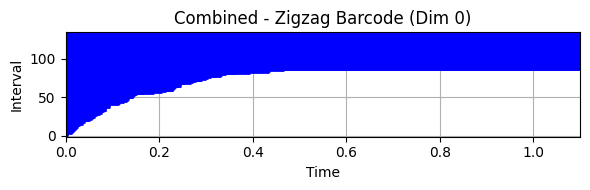

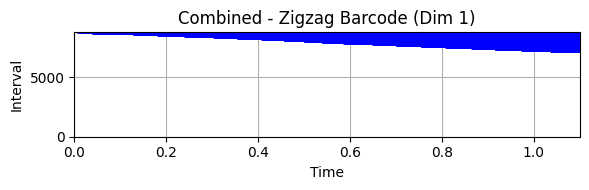

In [26]:
# for dim, dgm in enumerate(dgms_prox):
#     plot_barcode(dgm, dim, title_prefix='Proximity')

# for dim, dgm in enumerate(dgms_death):
#     plot_barcode(dgm, dim, title_prefix='Deaths')

for dim, dgm in enumerate(dgms_both):
    plot_barcode(dgm, dim, title_prefix='Combined')


In [1]:
df.describe()

NameError: name 'df' is not defined

#### Example Scenario: (Mixed Method)
Imagine counties A, B, C forming a triangle on the map:
A-B, B-C, C-A all close together
A and B have high deaths → edge A-B enters early
B and C have high deaths → B-C enters early
C and A has a low-death county → that edge enters late
What happens?
You get a persistent H₁ loop, because the final triangle (A-B-C) can't be filled until much later
That loop persists over time → that delay reflects the presence of a low-death county weakening the connection
Key Insight:
A persistent 1-cycle in the combined method can signal a loop of high-death counties with a weak spot — a lower-death link that prevents full collapse into a 2-simplex.
So it’s not that the loop is "empty" (as in low-death zone), but that there's heterogeneity:
High-death structure almost forms a strong connected region
But one edge is weak → and that’s what keeps the loop alive
So how is this useful?
You might identify:
Clusters of high overdose activity that are "almost" fully connected, but fragmented by a county with lower death count
Potential intervention points: counties bridging high-death zones but not yet overwhelmed themselves



Method	What it emphasizes	Interpretation
- Proximity	Geographic closeness	Spatial clustering and layout
- Death counts	Overdose intensity (high death)	Hotspot regions and their shape
- Combined	Geography + death intensity	Hotspots and their spatial connectivity, including weak links

In [55]:
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial.distance import pdist, squareform
year = 2019
method = 'none'
# def build_zigzag_filtration(df, year, method='none', radius=0.5):
df_year = df_filtered1[df_filtered1['Overdose Death Year'] == year].copy()
deaths = df_year['Overdose Death Count'].values
coords = df_year[['Latitude', 'Longitude']].values
counties = df_year['County'].values

    # Distance matrix
dist_matrix = squareform(pdist(coords))
# Get thresholds based on method
if method == 'none':
    thresholds = [float('-inf'), float('inf')]
elif method == 'std':
    μ, σ = np.mean(deaths), np.std(deaths)
    thresholds = [μ + σ, μ, μ - σ]
elif method == 'quantile':
    thresholds = np.quantile(deaths, [0.75, 0.5, 0.25])
else:
    raise ValueError("Method must be 'none', 'std', or 'quantile'.")

# Build zigzag filtration
times = []
filtration_steps = []

for i, threshold in enumerate(thresholds):
    mask = deaths >= threshold
    indices = np.where(mask)[0]
    pts = coords[indices]
    simplex_tree = d.Filtration()

    # Add 0-simplices
    for idx in indices:
        simplex_tree.append(d.Simplex([idx], 0))

    # Add 1-simplices (edges) based on radius
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            if dist_matrix[indices[i], indices[j]] <= radius:
                simplex_tree.append(d.Simplex([indices[i], indices[j]], 1))

    simplex_tree.sort()
    filtration_steps.append(simplex_tree)
    times.append(i)

    # # Combine zigzag filtration
    # zz = d.zigzag.Filtration()
    # for t, step in zip(times, filtration_steps):
    #     zz.append((t, step))

    # # Compute persistence
    # ZZ, dgms, cells = d.zigzag_homology_persistence(zz, times)
    # return dgms


NameError: name 'radius' is not defined

In [56]:
df_filtered1.columns

Index(['Overdose Death Year', 'County', 'Latitude', 'Longitude',
       'Overdose Death Count'],
      dtype='object')

In [52]:
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial.distance import pdist, squareform

def build_zigzag_filtration(df, year, method='none', radius=0.5):
    df_year = df[df['Overdose Death Year'] == year].copy()
    deaths = df_year['Overdose Death Count'].values
    coords = df_year[['Latitude', 'Longitude']].values
    n_points = len(deaths)

    # Distance matrix (full for all points in year)
    dist_matrix = squareform(pdist(coords))

    # Thresholds based on method
    if method == 'none':
        thresholds = [float('-inf'), float('inf')]
    elif method == 'std':
        μ, σ = np.mean(deaths), np.std(deaths)
        thresholds = [μ + σ, μ, μ - σ]
    elif method == 'quantile':
        thresholds = np.quantile(deaths, [0.75, 0.5, 0.25])
    else:
        raise ValueError("Method must be 'none', 'std', or 'quantile'.")

    # For each threshold/time step, find indices of points included
    time_steps = []
    included_points = []

    for t, threshold in enumerate(thresholds):
        mask = deaths >= threshold
        indices = set(np.where(mask)[0])
        time_steps.append(t)
        included_points.append(indices)

    # Create the union of all simplices over all steps (vertices and edges)
    all_vertices = set()
    all_edges = set()

    for pts in included_points:
        all_vertices |= pts
        # Add edges between pairs within radius
        pts_list = list(pts)
        for i in range(len(pts_list)):
            for j in range(i+1, len(pts_list)):
                if dist_matrix[pts_list[i], pts_list[j]] <= radius:
                    all_edges.add(tuple(sorted((pts_list[i], pts_list[j]))))

    # Build the filtration: list of simplices (vertices + edges)
    simplices = []
    # For vertices, simplex = [vertex_index]
    for v in sorted(all_vertices):
        simplices.append(d.Simplex([v]))

    # For edges, simplex = [v1, v2]
    for e in sorted(all_edges):
        simplices.append(d.Simplex(list(e)))

    # Sort simplices by dimension and then by vertex indices (required by Dionysus)
    simplices.sort(key=lambda s: (len(s), s.vertices))

    # Build the Filtration object
    filtration = d.Filtration(simplices)

    # For each simplex, specify the list of times it enters/leaves the zigzag filtration
    # We do this by checking, for each time step, if the simplex is present (all vertices included)

    times = []  # list of lists: times[i] = [enter, leave, enter2, leave2, ...] for simplex i

    for simplex in filtration:
        simplex_vertices = set(simplex)
        presence_times = []
        # We'll find intervals [enter, leave] when simplex is present
        present_flags = [simplex_vertices.issubset(pts) for pts in included_points]

        # Convert presence_flags (list of bools over time_steps) into enter/leave times
        # Zigzag allows simplices to enter and leave multiple times.
        # We'll record intervals of presence:
        intervals = []
        inside = False
        for t_idx, present in enumerate(present_flags):
            if present and not inside:
                # enters at this time
                enter = time_steps[t_idx]
                inside = True
            elif not present and inside:
                # leaves at previous time
                leave = time_steps[t_idx - 1]
                intervals.append((enter, leave))
                inside = False
        # If still inside at the end:
        if inside:
            leave = time_steps[-1]
            intervals.append((enter, leave))

        # Flatten intervals into one list of times as expected by d.zigzag:
        # times = [enter, leave, enter2, leave2, ...]
        times.append([val for interval in intervals for val in interval])

    # Now compute zigzag persistence
    zz, dgms, cells = d.zigzag_homology_persistence(filtration, times)

    return dgms

# Example usage:
# df_filtered1 = pd.read_csv('your_overdose_data.csv')
# dgms_none = build_zigzag_filtration(df_filtered1, 2019, method='none', radius=0.5)

# You can print diagrams:
# for dim, dgm in enumerate(dgms_none):
#     print(f"Dimension {dim}:")
#     for p in dgm:
#         print(p)


In [53]:
# Load your dataset
# df = pd.read_csv('your_overdose_data.csv')

year = 2019
dgms_none = build_zigzag_filtration(df_filtered1, year, method='none')
dgms_std = build_zigzag_filtration(df_filtered1, year, method='std')
dgms_quant = build_zigzag_filtration(df_filtered1, year, method='quantile')


AttributeError: 'dionysus._dionysus.Simplex' object has no attribute 'vertices'